In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [8]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [10]:
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [18]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1: n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [122]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size) ** 0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


tensor(-0.0060) tensor(0.9945)
tensor(-0.0013) tensor(0.9973)


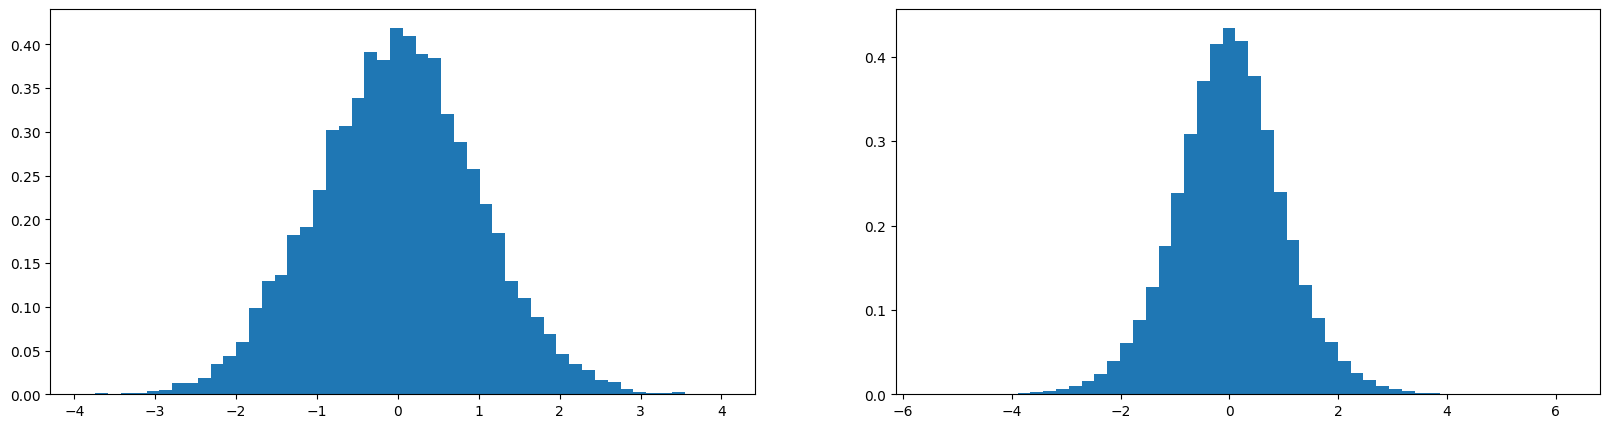

In [123]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 10**-0.5
y = x @ w;
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [106]:
(torch.randn(10000) * 0.2).std()

tensor(0.2009)

In [124]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    lr = 0.1 if i < max_steps / 2 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2820
  10000/ 200000: 2.4278
  20000/ 200000: 2.3188
  30000/ 200000: 2.1798
  40000/ 200000: 2.1292
  50000/ 200000: 2.0417
  60000/ 200000: 1.8676
  70000/ 200000: 2.2485
  80000/ 200000: 2.0067
  90000/ 200000: 2.1579
 100000/ 200000: 2.0240
 110000/ 200000: 2.0519
 120000/ 200000: 2.1314
 130000/ 200000: 2.0662
 140000/ 200000: 1.7506
 150000/ 200000: 2.1649
 160000/ 200000: 1.7519
 170000/ 200000: 1.9192
 180000/ 200000: 2.2092
 190000/ 200000: 1.8819


In [118]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [119]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

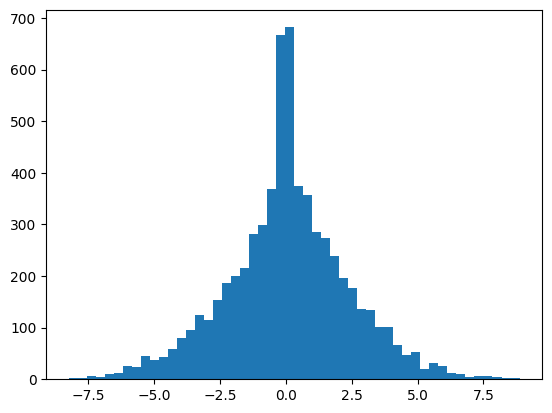

In [109]:
plt.hist(hpreact.view(-1).tolist(), 50);

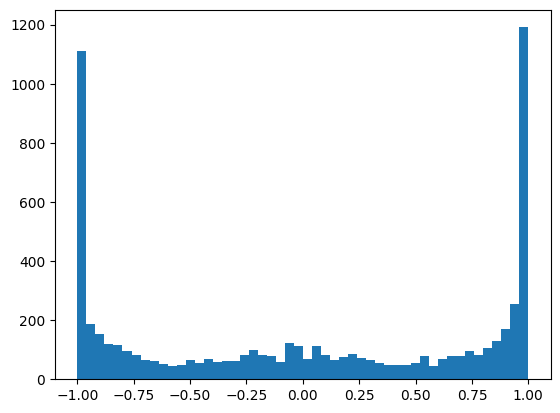

In [110]:
plt.hist(h.view(-1).tolist(), 50);

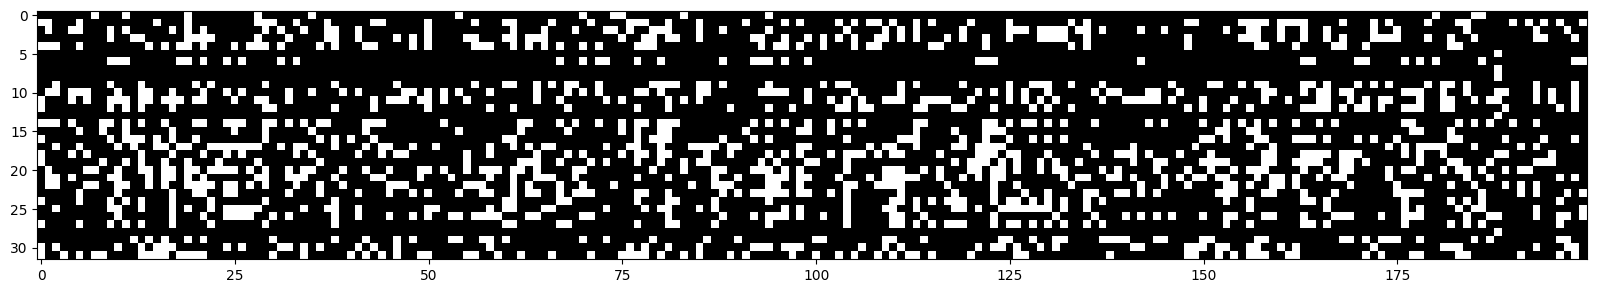

In [111]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [83]:
logits.shape

torch.Size([32, 27])

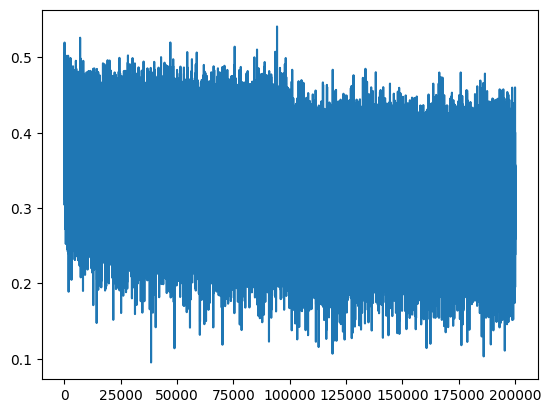

In [82]:
plt.plot(lossi)

In [128]:
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1

    # measure the mean and std over the entire set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [130]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.050018310546875
val 2.1048202514648438


In [49]:
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break;

    print(''.join(itos[i] for i in out))

carmahzaan.
hari.
kimri.
reh.
cassanden.
jazheen.
amerric.
kaqei.
nelonia.
chaiiv.
kaleigh.
ham.
joce.
quint.
sulin.
alianni.
wajerogiearyni.
jaxen.
ivran.
edde.


In [50]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [69]:
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([-12.2081,   3.8370,   2.2055,  -9.3960]),
 tensor([8.9972e-08, 8.3638e-01, 1.6362e-01, 1.4976e-06]),
 tensor(1.8102))

In [51]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BathNorm1D:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x-xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momenutum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
            return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)
C= torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(), 
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [52]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break

      0/ 200000: 3.2962


layer 1 (      Tanh): mean -0.02, std 0.75, saturated: 20.25%
layer 3 (      Tanh): mean -0.00, std 0.69, saturated: 8.38%
layer 5 (      Tanh): mean +0.00, std 0.67, saturated: 6.62%
layer 7 (      Tanh): mean -0.01, std 0.66, saturated: 5.47%
layer 9 (      Tanh): mean -0.02, std 0.66, saturated: 6.12%


Text(0.5, 1.0, 'activation distribution')

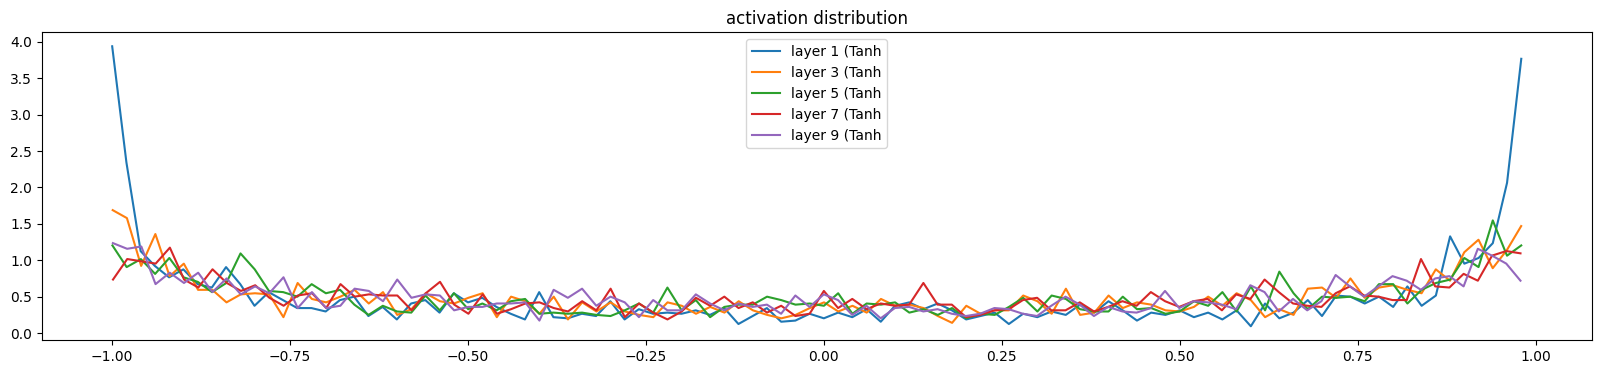

In [53]:
# visualize histo
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000010, std 4.205588e-04
layer 3 (      Tanh): mean -0.000003, std 3.991179e-04
layer 5 (      Tanh): mean +0.000003, std 3.743020e-04
layer 7 (      Tanh): mean +0.000015, std 3.290473e-04
layer 9 (      Tanh): mean -0.000014, std 3.054035e-04


Text(0.5, 1.0, 'activation distribution')

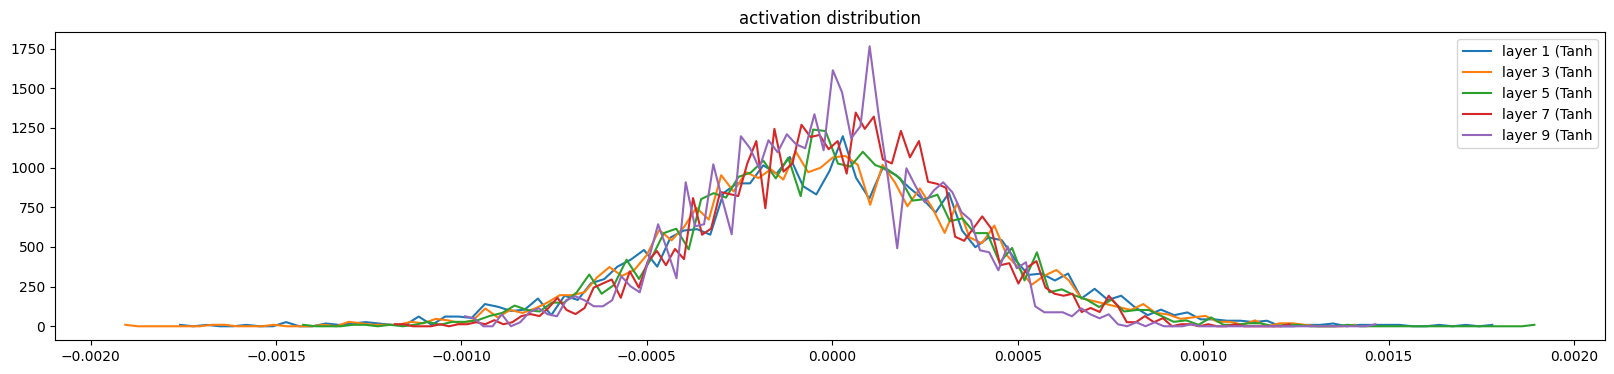

In [54]:
# visualize histo
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')